In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Column, Integer, String, Float, and_, or_, distinct, cast
from sqlalchemy.sql import label

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#connect to inspector to get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns_ea = inspector.get_columns('measurement')
for c in columns_ea:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Get a list of column names and types
columns_ea = inspector.get_columns('station')
for c in columns_ea:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#check data
engine.execute('SELECT * FROM measurement limit 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# Calculate the date 1 year ago from the last data point in the database
start_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
start_date

('2017-08-23')

In [16]:
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [17]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_ago).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results,columns=['date','prcp'])
df.set_index('date',inplace=True)

In [19]:
# Sort the dataframe by date
df = df.sort_values('date')

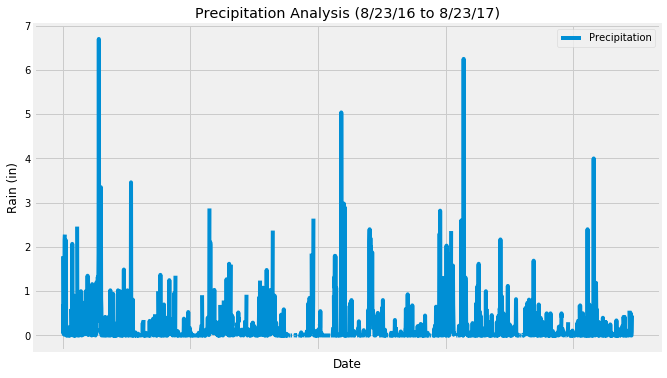

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Rain (in)")
plt.title("Precipitation Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, label('count',func.count(Measurement.station))).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in stations:
    print(f"{station} had {count} observations.")

USC00519281 had 2772 observations.
USC00519397 had 2724 observations.
USC00513117 had 2709 observations.
USC00519523 had 2669 observations.
USC00516128 had 2612 observations.
USC00514830 had 2202 observations.
USC00511918 had 1979 observations.
USC00517948 had 1372 observations.
USC00518838 had 511 observations.


In [24]:
stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in stations:
    print(f"{station} had {count} observations.")

USC00519281 had 2772 observations.
USC00519397 had 2724 observations.
USC00513117 had 2709 observations.
USC00519523 had 2669 observations.
USC00516128 had 2612 observations.
USC00514830 had 2202 observations.
USC00511918 had 1979 observations.
USC00517948 had 1372 observations.
USC00518838 had 511 observations.


### The most active station is USC00519281, followed by USC00519397 and USC00513117.

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
minT = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
maxT = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
avgT = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(f"The lowest temperature is {minT[0]}, the highest temperature is {maxT[0]}, and the average temperature is\
 {avgT[0]}.")

The lowest temperature is 54.0, the highest temperature is 85.0, and the average temperature is 71.66378066378067.


In [26]:
# Choose the station with the highest number of temperature observations.
MostT = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
print(f"Station {MostT[0]} has the highest number of temperature observations with count {MostT[1]}.")

Station USC00519281 has the highest number of temperature observations with count 2772.


In [27]:
MostDT = session.query(Measurement.station,func.count(distinct(Measurement.tobs))).\
group_by(Measurement.station).order_by(func.count(distinct(Measurement.tobs)).desc()).first()
print(f"The station with the most distinct number of temperatures is {MostDT[0]} with count {MostDT[1]}.")

The station with the most distinct number of temperatures is USC00511918 with count 34.


In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Find the last date
queryDate = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').\
order_by(Measurement.date.desc()).first()
start_date = dt.datetime.strptime(queryDate[0],'%Y-%m-%d')
start_date

datetime.datetime(2017, 8, 18, 0, 0)

In [29]:
query = session.query(func.max(Measurement.date)).first()
maxDate = dt.datetime.strptime(query[0],'%Y-%m-%d')
year_ago = maxDate - dt.timedelta(days=365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [30]:
# Set last 12 months of temps in Temps
Temps = session.query(Measurement.station,Measurement.tobs).\
filter(and_(Measurement.station == 'USC00519281',Measurement.date>=year_ago)).all()

In [31]:
#check query
Temps[0:9]

[('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0)]

In [32]:
#Create dataframe for histogram
temp_df = pd.DataFrame(Temps)
temp_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0


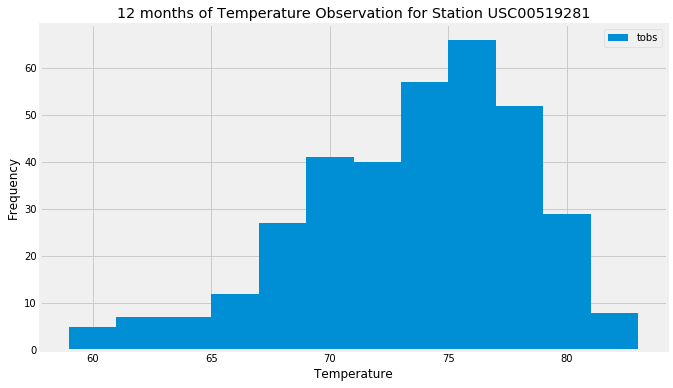

In [33]:
temp_df.hist('tobs', bins=12,figsize=(10,6))
plt.title('12 months of Temperature Observation for Station USC00519281')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(['tobs'])
plt.show()

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-07-01','2017-07-14'))

[(69.0, 78.11627906976744, 87.0)]


In [36]:
# create dataframe for matplotlib
calc_df = pd.DataFrame(calc_temps('2017-07-01','2017-07-14'),columns=['tmin','tave','tmax'])
calc_df.head()

,tmin,tave,tmax
0,69.0,78.116279,87.0


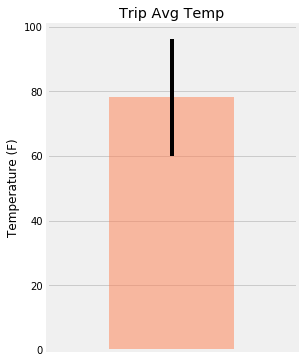

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_df.plot.bar(y='tave',yerr=(calc_df['tmax']-calc_df['tmin']),
                 title='Trip Avg Temp',color='coral',alpha=0.5,figsize=(4,6),legend=False)
plt.ylabel('Temperature (F)')
# hide x-axis label
plt.xticks(np.arange(0,0))
plt.show()

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]
session.query(*sel,label('total',func.sum(Measurement.prcp))).\
        filter(Measurement.date >= '2017-07-01').filter(Measurement.date <= '2017-07-14').\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.1, 24.93),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.08,
  14.309999999999985),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.06,
  7.199999999999992),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  None,
  3.4199999999999995),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.02,
  1.8900000000000012),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  None,
  1.1700000000000002),
 ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, None, None)]

## Optional Challenge Assignment

In [39]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [48]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []
for date in range(1,14):
    daily_str = "07-"+str(date).zfill(2)
    daily = daily_normals(daily_str)[0]
    normals.append(daily)

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2017-07-01','%Y-%m-%d')
end_date = dt.datetime.strptime('2017-07-14','%Y-%m-%d')

# Use the start and end date to create a range of dates

date_range = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings

monthDay = []
for date in date_range:
    monthDay.append(date.strftime('%m-%d'))
    
# Loop through the list of %m-%d strings and calculate the normals for each date

normList = []
for day in monthDay:
    norms = daily_normals(day)[0]
    normList.append(norms)
    
normList

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [62]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normList, columns=['TMIN','TAVG','TMAX'])
df['date'] = date_range
tripDf = df.set_index('date')
tripDf

,TMIN,TAVG,TMAX
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


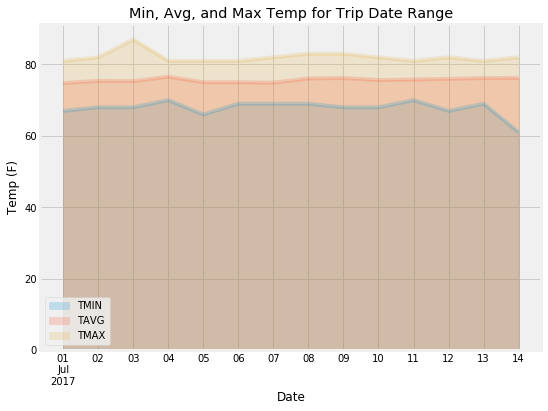

In [83]:
# Plot the daily normals as an area plot with `stacked=False`
tripDf.plot.area(stacked=False,figsize=(8,6),alpha=0.2)
plt.title('Min, Avg, and Max Temp for Trip Date Range')
plt.xticks(date_range)
plt.ylabel('Temp (F)')
plt.xlabel('Date')
plt.show()